### Import packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import dill
import yaml
import numpy as np
import pandas as pd
import ast
import collections
import seaborn as sns
sns.set(style='ticks')

### Import submodular-optimization packages

In [2]:
sys.path.insert(0, "/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/submodular_optimization/")

### Visualizations directory

In [3]:
VIZ_DIR = os.path.abspath("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/submodular_optimization/viz/")

### Legends and style dictionary

In [4]:
legends = {
    "partition_matroid_greedy":"Greedy",
    "cost_scaled_partition_matroid_lazy_greedy":"MCSLG",
    "baseline_topk_matroid": 'Top-k-Experts-Matroid'
}

legends = collections.OrderedDict(sorted(legends.items()))

line_styles = {'partition_matroid_greedy':':',
               'cost_scaled_partition_matroid_lazy_greedy':'-',
              'baseline_topk_matroid':'--'}

line_styles = collections.OrderedDict(sorted(line_styles.items()))

marker_style = {'partition_matroid_greedy':'s',
                'cost_scaled_partition_matroid_lazy_greedy':'x',
               'baseline_topk_matroid':'d'}


marker_style = collections.OrderedDict(sorted(marker_style.items()))

marker_size = {'partition_matroid_greedy':25,
               'cost_scaled_partition_matroid_lazy_greedy':30,
              'baseline_topk_matroid':22}


marker_size = collections.OrderedDict(sorted(marker_size.items()))

marker_edge_width = {'partition_matroid_greedy':6,
               'cost_scaled_partition_matroid_lazy_greedy':10,
                    'baseline_topk_matroid':6}


marker_edge_width = collections.OrderedDict(sorted(marker_edge_width.items()))

line_width = {'partition_matroid_greedy':5,
              'cost_scaled_partition_matroid_lazy_greedy':5,
             'baseline_topk_matroid':5}

line_width = collections.OrderedDict(sorted(line_width.items()))


name_objective = "Combined objective (g)"
fontsize = 53
legendsize = 42
labelsize = 53
x_size = 20
y_size = 16

### Plotting utilities

In [5]:
def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})

In [6]:
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()

In [7]:
def save_fig(fig, filename):
    fig.savefig(os.path.join(VIZ_DIR, filename), dpi=600, format='pdf', bbox_inches='tight')

### Plots

#### Details
Original marginal gain: $$g(e|S) = f(e|S) - w(e)$$
Scaled marginal gain: $$\tilde{g}(e|S) = f(e|S) - 2w(e)$$ 

#### Algorithms:
1. Greedy: The algorithm performs iterations i = 0,...,n-1. In each iteration the algorithm selects the element that maximizes the original marginal gain. It adds the element to the solution if the original marginal gain of the element is >= 0. It updates the set of valid elements by keeping only those elements that when added to the solution preserve that it belongs to the independent set. The running time is O($n^2$).

2. Cost Greedy (Algorithm 1 from arXiv): The algorithm performs iterations i = 0,...,n-1. In each iteration the algorithm selects the element that maximizes the scaled marginal gain. It adds the element to the solution if the original marginal gain of the element is >= 0. It updates the set of valid elements by keeping only those elements that when added to the solution preserve that it belongs to the independent set. The running time is O($n^2$).


3. Cost Lazy Greedy (Algorithm 1 from arXiv with lazy eval): The algorithm first initializes a max heap with all the elements. The key of each element is its scaled marginal gain and the value is the element id. If the original marginal gain of an element is < 0 the algorithm discards the element and never inserts it in the heap. Then, for 0,...,n-1 iterations the algorithm does the following: (i) pops the top element from the heap and computes its new scaled marginal gain, (ii) It checks the old scaled marginal gain of the next element in the heap, (iii) if the popped element's new scaled marginal gain is >= the next elements's old gain we return the popped element, otherwise if its new original marginal gain is >= 0 we reinsert the element to the heap and repeat step iii. If the returned element's original marginal gain is >= 0 we add it to the solution and update the set of valid elements. The algorithm returns a solution S: f(S) - w(S) >= (1/2)f(OPT) - w(OPT). The running time in the worst case is O($n^2$).

4. Cost Lazy Scaled Greedy: Same as above. The only thing that changes is step (iii) where we reinsert an element to the heap if its scaled marginal gain is >= 0 (instead of the original gain).


#### Performance comparison for random partitions

The experimental setting for the random partitions is the following:
1. Get a sample of users
2. Consider 20 partitions and randomly assign a user to a partition.
3. From each partition the solution can select only one user in this setting.

In [8]:

df1 = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_04_freelancer_random_pop01_rare01.csv",
                header=0,
                index_col=False)

df1.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k','cardinality_constraint','num_of_partitions']

df2 = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_04_freelancer_random_pop01_rare01_sup.csv",
                header=0,
                index_col=False)

df2.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k','cardinality_constraint','num_of_partitions']

frames = []
frames.append(df1)
frames.append(df2)

df = pd.concat(frames)

In [9]:
def plot_performance_comparison(df):
    palette = sns.color_palette(['#b30000','#dd8452', '#8172b3', '#4c72b0', '#8172b3',
                                 '#55a868', 
                                 '#8172b3', '#937860', '#da8bc3', '#8c8c8c', 
                                 '#ccb974', '#64b5cd'],3)
    ax = sns.lineplot(x='cardinality_constraint', y='val', data=df, 
                      hue='Algorithm', ci='sd',
                      mfc='none',palette=palette)
    
    i = 0
    for key, val in line_styles.items():
        ax.lines[i].set_linestyle(val)
        # ax.lines[i].set_color(colors[key])
        ax.lines[i].set_linewidth(line_width[key])
        ax.lines[i].set_marker(marker_style[key])
        ax.lines[i].set_markersize(marker_size[key])
        ax.lines[i].set_markeredgewidth(marker_edge_width[key])
        ax.lines[i].set_markeredgecolor(None)
        i += 1
    
    plt.yticks(np.arange(0, 45000, 5000))
    # plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Constraint (k)', fontsize=fontsize)
    plt.ylabel(name_objective, fontsize=fontsize)
    # plt.title('Performance comparison')
    fig = plt.gcf()
    figlegend = plt.legend([val for key,val in legends.items()],loc=3, bbox_to_anchor=(0., 1.02, 1., .102),
               ncol=2, mode="expand", borderaxespad=0., frameon=False,prop={'size': legendsize})
    ax = plt.gca()
    plt.gca().tick_params(axis='y', labelsize=labelsize)
    plt.gca().tick_params(axis='x', labelsize=labelsize)
    return fig, ax

/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


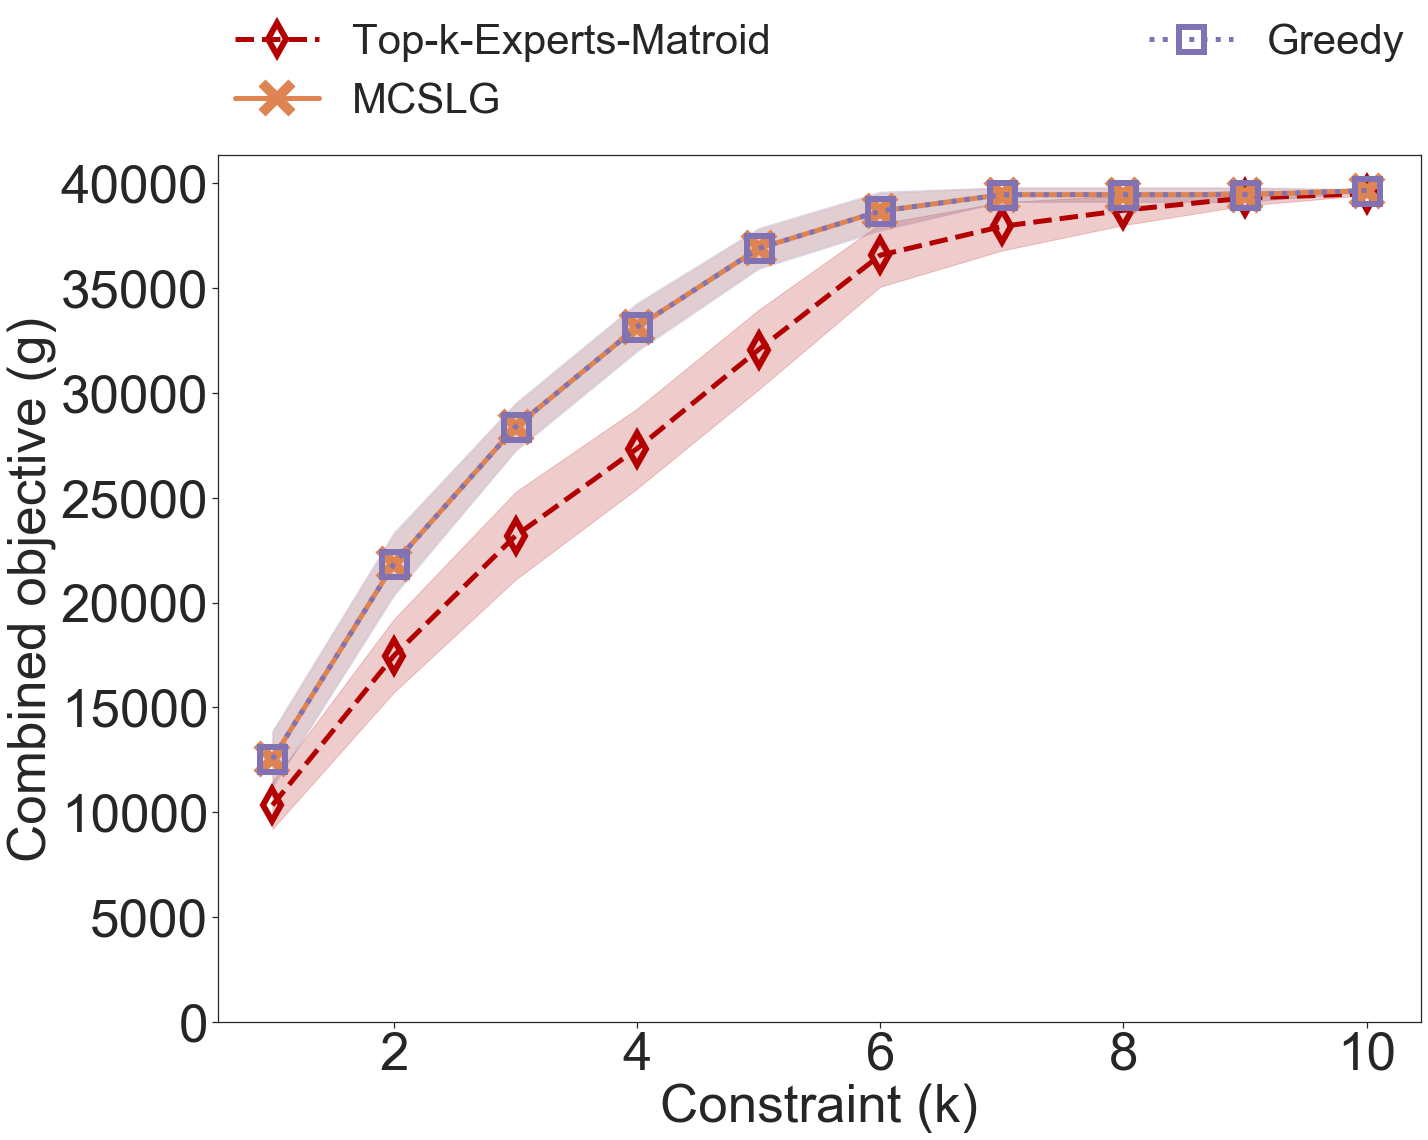

In [10]:
df = df[(df.Algorithm == 'partition_matroid_greedy')
        |(df.Algorithm == 'cost_scaled_partition_matroid_lazy_greedy')
        |(df.Algorithm == 'baseline_topk_matroid')
    ]

df0 = df[(df['num_of_partitions'] == 5)]
df0.sort_values(by ='Algorithm',inplace=True)
set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, x_size, y_size)
save_fig(fig,'score_partition_freelancer_random_pop01_rare01.pdf')

#### Running time comparison for random partitions

In [11]:
df1 = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_04_freelancer_random_pop01_rare01.csv",
                header=0,
                index_col=False)

df1.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k','cardinality_constraint','num_of_partitions']

df2 = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_04_freelancer_random_pop01_rare01_sup.csv",
                header=0,
                index_col=False)

df2.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k','cardinality_constraint','num_of_partitions']

frames = []
frames.append(df1)
frames.append(df2)

df = pd.concat(frames)

In [12]:
legends = {
    "partition_matroid_greedy":"Greedy",
    "cost_scaled_partition_matroid_lazy_greedy":"MCSLG",
    "baseline_topk_matroid": 'Top-k-Experts-Matroid',
    "cost_scaled_partition_matroid_greedy":"MCSG"
}

legends = collections.OrderedDict(sorted(legends.items()))

line_styles = {'partition_matroid_greedy':':',
               'cost_scaled_partition_matroid_lazy_greedy':'-',
              'baseline_topk_matroid':'--',
              'cost_scaled_partition_matroid_greedy':"-"}

line_styles = collections.OrderedDict(sorted(line_styles.items()))

marker_style = {'partition_matroid_greedy':'s',
                'cost_scaled_partition_matroid_lazy_greedy':'x',
               'baseline_topk_matroid':'d',
               "cost_scaled_partition_matroid_greedy":"x"}


marker_style = collections.OrderedDict(sorted(marker_style.items()))

marker_size = {'partition_matroid_greedy':25,
               'cost_scaled_partition_matroid_lazy_greedy':30,
              'baseline_topk_matroid':22,
               "cost_scaled_partition_matroid_greedy":30}


marker_size = collections.OrderedDict(sorted(marker_size.items()))

marker_edge_width = {'partition_matroid_greedy':6,
               'cost_scaled_partition_matroid_lazy_greedy':10,
                    'baseline_topk_matroid':6,
                "cost_scaled_partition_matroid_greedy":10}



marker_edge_width = collections.OrderedDict(sorted(marker_edge_width.items()))

line_width = {'partition_matroid_greedy':5,
              'cost_scaled_partition_matroid_lazy_greedy':5,
             'baseline_topk_matroid':5,
            "cost_scaled_partition_matroid_greedy":5}


line_width = collections.OrderedDict(sorted(line_width.items()))


name_objective = "Combined objective (g)"
fontsize = 53
legendsize = 42
labelsize = 53
x_size = 20
y_size = 16

In [13]:
def plot_performance_comparison(df):
    palette = sns.color_palette(['#b30000','#dd8452', '#4c72b0', '#8172b3',
                                 '#55a868', 
                                 '#8172b3', '#937860', '#da8bc3', '#8c8c8c', 
                                 '#ccb974', '#64b5cd'],4)
    ax = sns.lineplot(x='cardinality_constraint', y='runtime', data=df, 
                      hue='Algorithm', ci='sd',
                      mfc='none',palette=palette)
    
    i = 0
    for key, val in line_styles.items():
        ax.lines[i].set_linestyle(val)
        # ax.lines[i].set_color(colors[key])
        ax.lines[i].set_linewidth(line_width[key])
        ax.lines[i].set_marker(marker_style[key])
        ax.lines[i].set_markersize(marker_size[key])
        ax.lines[i].set_markeredgewidth(marker_edge_width[key])
        ax.lines[i].set_markeredgecolor(None)
        i += 1
    
    # plt.yticks(np.arange(0, 45000, 5000))
    # plt.xticks(np.arange(0, 1.1, 0.1))
    plt.ylabel('Time (sec)', fontsize=fontsize)
    plt.xlabel('Constraint (k)', fontsize=fontsize)
    # plt.title('Performance comparison')
    fig = plt.gcf()
    figlegend = plt.legend([val for key,val in legends.items()],loc=3, bbox_to_anchor=(0., 1.02, 1., .102),
               ncol=2, mode="expand", borderaxespad=0., frameon=False,prop={'size': legendsize})
    ax = plt.gca()
    plt.gca().tick_params(axis='y', labelsize=labelsize)
    plt.gca().tick_params(axis='x', labelsize=labelsize)
    return fig, ax

/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


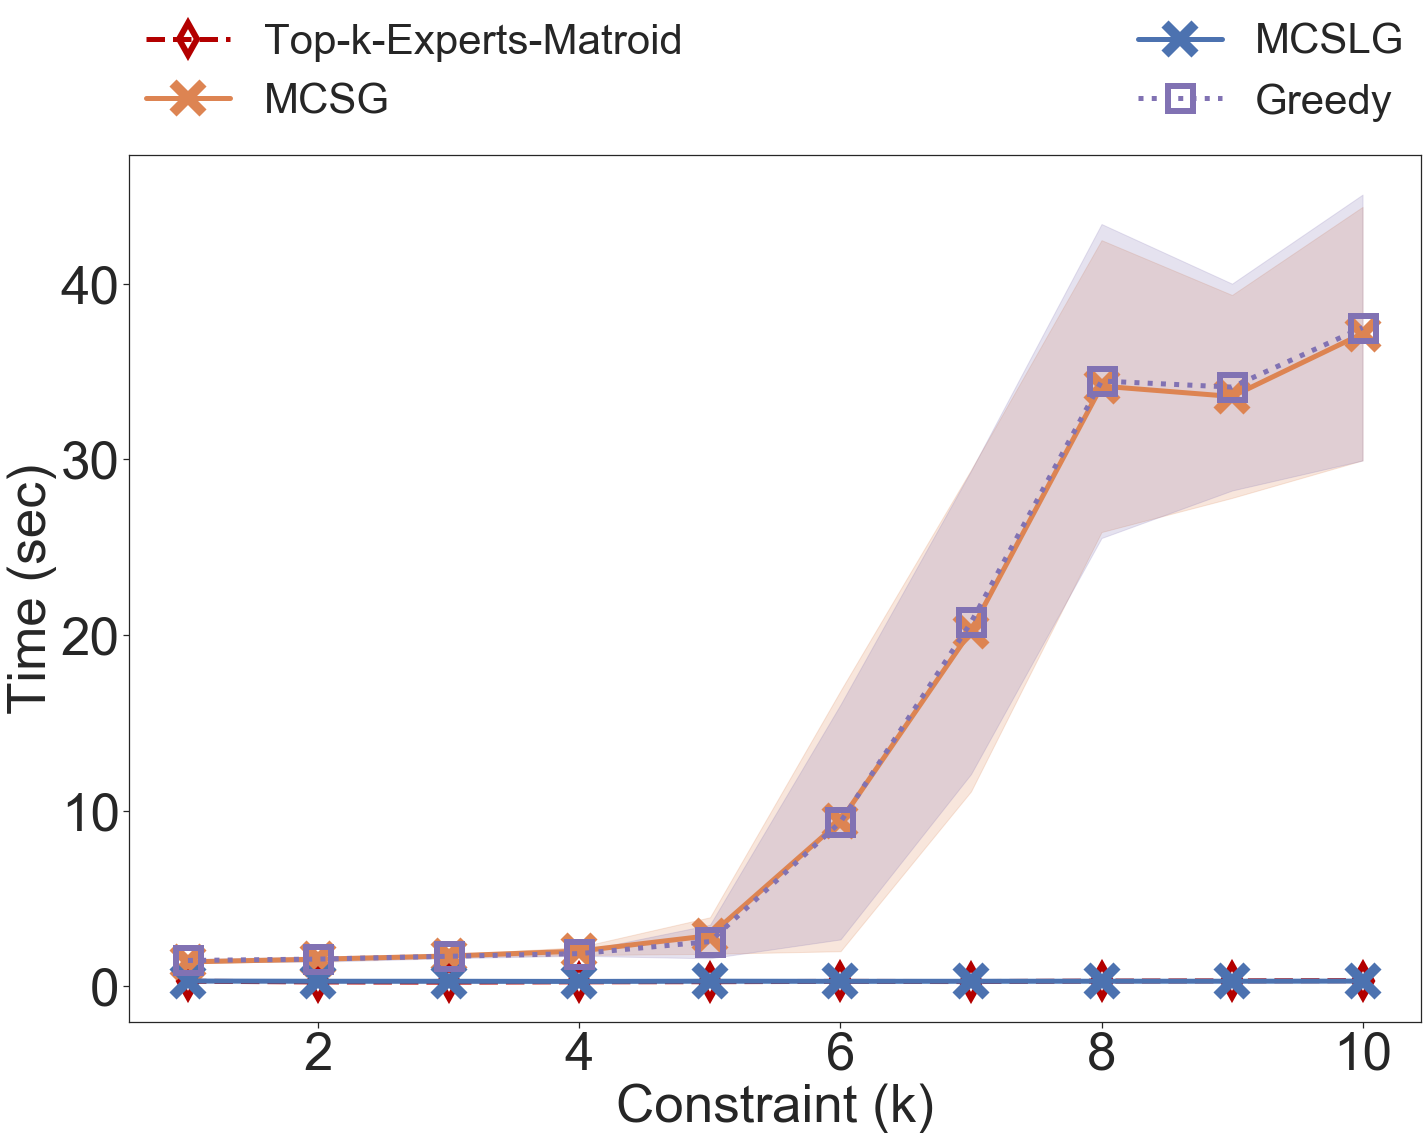

In [14]:

df = df[(df.Algorithm == 'partition_matroid_greedy')
        |(df.Algorithm == 'cost_scaled_partition_matroid_lazy_greedy')
        |(df.Algorithm == 'baseline_topk_matroid')
        |(df.Algorithm == 'cost_scaled_partition_matroid_greedy')
    ]

df0 = df[(df['num_of_partitions'] == 5)]
df0.sort_values(by ='Algorithm',inplace=True)
set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, x_size, y_size)
save_fig(fig,'time_partition_freelancer_random_pop01_rare01.pdf')

In [15]:
legends = {
    "partition_matroid_greedy":"Greedy",
    "cost_scaled_partition_matroid_lazy_greedy":"MCSLG",
    "baseline_topk_matroid": 'Top-k-Experts-Matroid'
}

legends = collections.OrderedDict(sorted(legends.items()))

line_styles = {'partition_matroid_greedy':':',
               'cost_scaled_partition_matroid_lazy_greedy':'-',
              'baseline_topk_matroid':'--'}

line_styles = collections.OrderedDict(sorted(line_styles.items()))

marker_style = {'partition_matroid_greedy':'s',
                'cost_scaled_partition_matroid_lazy_greedy':'x',
               'baseline_topk_matroid':'d'}


marker_style = collections.OrderedDict(sorted(marker_style.items()))

marker_size = {'partition_matroid_greedy':25,
               'cost_scaled_partition_matroid_lazy_greedy':30,
              'baseline_topk_matroid':22}


marker_size = collections.OrderedDict(sorted(marker_size.items()))

marker_edge_width = {'partition_matroid_greedy':6,
               'cost_scaled_partition_matroid_lazy_greedy':10,
                    'baseline_topk_matroid':6}


marker_edge_width = collections.OrderedDict(sorted(marker_edge_width.items()))

line_width = {'partition_matroid_greedy':5,
              'cost_scaled_partition_matroid_lazy_greedy':5,
             'baseline_topk_matroid':5}

line_width = collections.OrderedDict(sorted(line_width.items()))


name_objective = "Combined objective (g)"
fontsize = 53
legendsize = 42
labelsize = 53
x_size = 20
y_size = 16

In [16]:

df1 = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_04_freelancer_salary_pop01_rare01.csv",
                header=0,
                index_col=False)

df1.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k','cardinality_constraint','num_of_partitions']

df2 = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_04_freelancer_salary_pop01_rare01_sup.csv",
                header=0,
                index_col=False)

df2.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k','cardinality_constraint','num_of_partitions']

frames = []

frames.append(df1)
frames.append(df2)

df = pd.concat(frames)


#### Performance comparison for salary partitions

The experimental setting for the salary partitions is the following:
1. Get a sample of users
2. Create the ordering of the users' unique salary values. Divide the sorted salaries into 20 partitions.
3. Assign each user to her corresponding cost partition range.
3. From each partition the solution can select only one user in this setting.

In [17]:
def plot_performance_comparison(df):
    palette = sns.color_palette(['#b30000','#dd8452', '#8172b3', '#4c72b0', '#8172b3',
                                 '#55a868', 
                                 '#8172b3', '#937860', '#da8bc3', '#8c8c8c', 
                                 '#ccb974', '#64b5cd'],3)
    ax = sns.lineplot(x='cardinality_constraint', y='val', data=df, 
                      hue='Algorithm', ci='sd',
                      mfc='none',palette=palette)
    
    i = 0
    for key, val in line_styles.items():
        ax.lines[i].set_linestyle(val)
        # ax.lines[i].set_color(colors[key])
        ax.lines[i].set_linewidth(line_width[key])
        ax.lines[i].set_marker(marker_style[key])
        ax.lines[i].set_markersize(marker_size[key])
        ax.lines[i].set_markeredgewidth(marker_edge_width[key])
        ax.lines[i].set_markeredgecolor(None)
        i += 1
    
    plt.yticks(np.arange(0, 45000, 5000))
    # plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Constraint (k)', fontsize=fontsize)
    plt.ylabel(name_objective, fontsize=fontsize)
    # plt.title('Performance comparison')
    fig = plt.gcf()
    figlegend = plt.legend([val for key,val in legends.items()],loc=3, bbox_to_anchor=(0., 1.02, 1., .102),
               ncol=2, mode="expand", borderaxespad=0., frameon=False,prop={'size': legendsize})
    ax = plt.gca()
    plt.gca().tick_params(axis='y', labelsize=labelsize)
    plt.gca().tick_params(axis='x', labelsize=labelsize)
    return fig, ax

/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


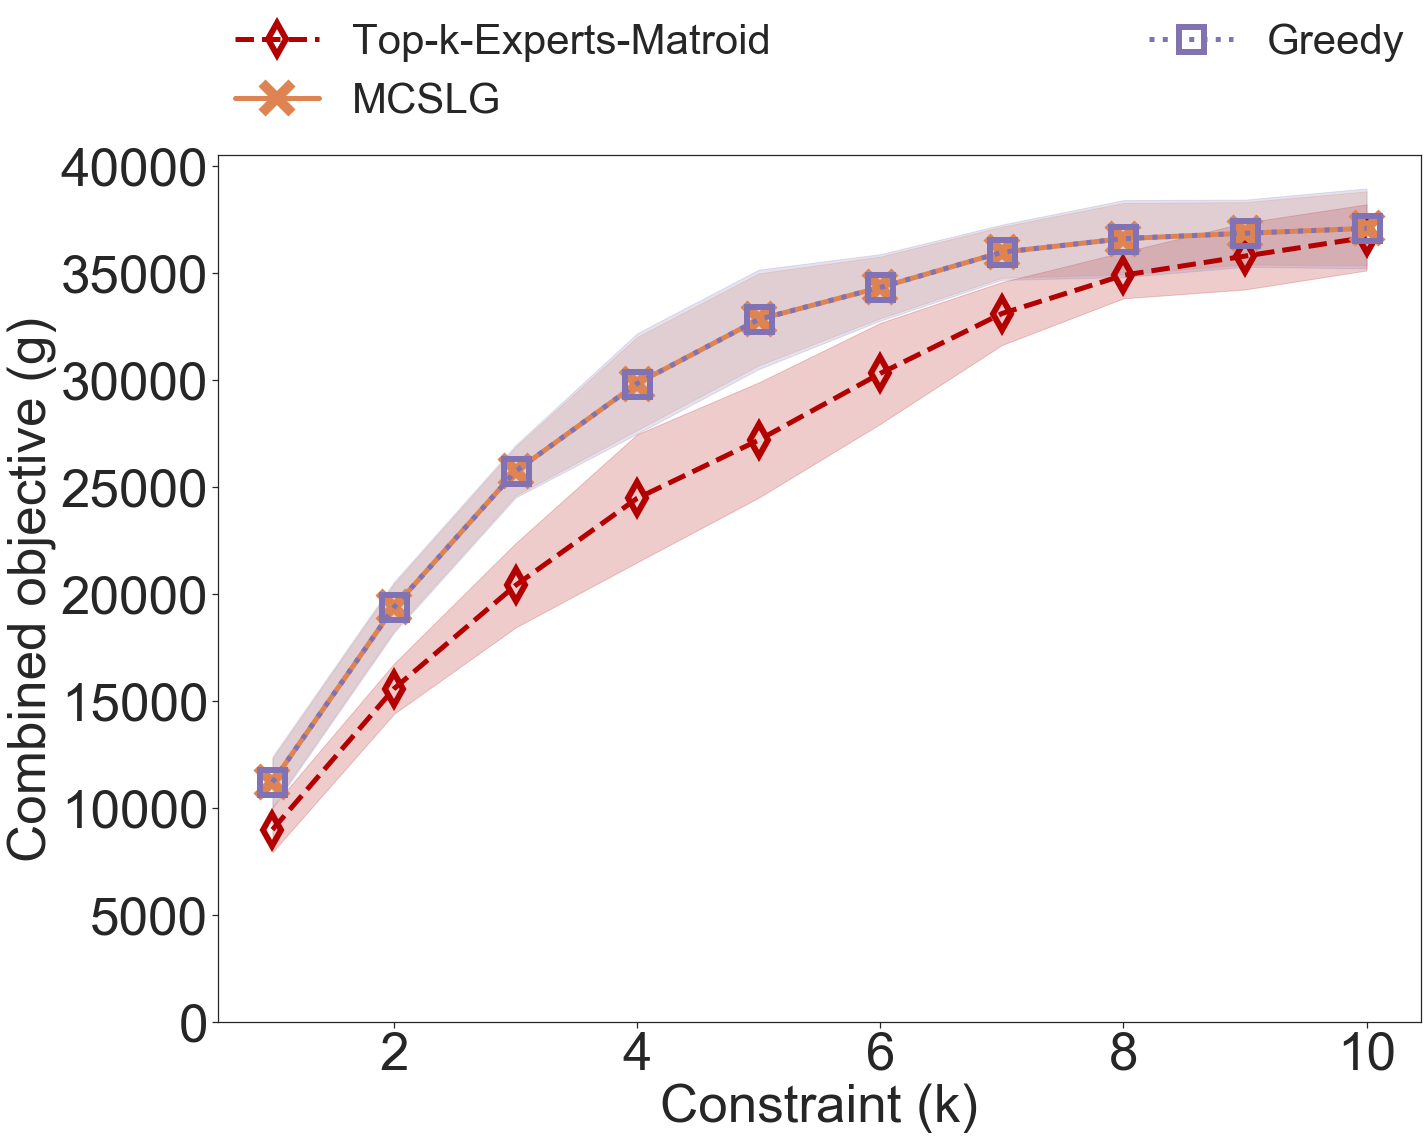

In [18]:
df = df[(df.Algorithm == 'partition_matroid_greedy')
        |(df.Algorithm == 'cost_scaled_partition_matroid_lazy_greedy')
        |(df.Algorithm == 'baseline_topk_matroid')
    ]

df0 = df[(df['num_of_partitions'] == 5)]
df0.sort_values(by ='Algorithm',inplace=True)
set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, x_size, y_size)
save_fig(fig,'score_partition_freelancer_salary_pop01_rare01.pdf')

#### Running time comparison for salary partitions

In [19]:
legends = {
    "partition_matroid_greedy":"Greedy",
    "cost_scaled_partition_matroid_lazy_greedy":"MCSLG",
    "baseline_topk_matroid": 'Top-k-Experts-Matroid',
    "cost_scaled_partition_matroid_greedy":"MCSG"
}

legends = collections.OrderedDict(sorted(legends.items()))

line_styles = {'partition_matroid_greedy':':',
               'cost_scaled_partition_matroid_lazy_greedy':'-',
              'baseline_topk_matroid':'--',
              'cost_scaled_partition_matroid_greedy':"-"}

line_styles = collections.OrderedDict(sorted(line_styles.items()))

marker_style = {'partition_matroid_greedy':'s',
                'cost_scaled_partition_matroid_lazy_greedy':'x',
               'baseline_topk_matroid':'d',
               "cost_scaled_partition_matroid_greedy":"x"}


marker_style = collections.OrderedDict(sorted(marker_style.items()))

marker_size = {'partition_matroid_greedy':25,
               'cost_scaled_partition_matroid_lazy_greedy':30,
              'baseline_topk_matroid':22,
               "cost_scaled_partition_matroid_greedy":30}


marker_size = collections.OrderedDict(sorted(marker_size.items()))

marker_edge_width = {'partition_matroid_greedy':6,
               'cost_scaled_partition_matroid_lazy_greedy':10,
                    'baseline_topk_matroid':6,
                "cost_scaled_partition_matroid_greedy":10}



marker_edge_width = collections.OrderedDict(sorted(marker_edge_width.items()))

line_width = {'partition_matroid_greedy':5,
              'cost_scaled_partition_matroid_lazy_greedy':5,
             'baseline_topk_matroid':5,
            "cost_scaled_partition_matroid_greedy":5}


line_width = collections.OrderedDict(sorted(line_width.items()))


name_objective = "Combined objective (g)"
fontsize = 53
legendsize = 42
labelsize = 53
x_size = 20
y_size = 16

In [20]:
df1 = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_04_freelancer_salary_pop01_rare01.csv",
                header=0,
                index_col=False)

df1.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k','cardinality_constraint','num_of_partitions']

df2 = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_04_freelancer_random_pop01_rare01_sup.csv",
                header=0,
                index_col=False)

df2.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k','cardinality_constraint','num_of_partitions']

frames = []
frames.append(df1)
frames.append(df2)

df = pd.concat(frames)

In [21]:
def plot_performance_comparison(df):
    palette = sns.color_palette(['#b30000','#dd8452', '#4c72b0', '#8172b3',
                                 '#55a868', 
                                 '#8172b3', '#937860', '#da8bc3', '#8c8c8c', 
                                 '#ccb974', '#64b5cd'],4)
    ax = sns.lineplot(x='cardinality_constraint', y='runtime', data=df, 
                      hue='Algorithm', ci='sd',
                      mfc='none',palette=palette)
    
    i = 0
    for key, val in line_styles.items():
        ax.lines[i].set_linestyle(val)
        # ax.lines[i].set_color(colors[key])
        ax.lines[i].set_linewidth(line_width[key])
        ax.lines[i].set_marker(marker_style[key])
        ax.lines[i].set_markersize(marker_size[key])
        ax.lines[i].set_markeredgewidth(marker_edge_width[key])
        ax.lines[i].set_markeredgecolor(None)
        i += 1
    
    # plt.yticks(np.arange(0, 45000, 5000))
    # plt.xticks(np.arange(0, 1.1, 0.1))
    plt.ylabel('Time (sec)', fontsize=fontsize)
    plt.xlabel('Constraint (k)', fontsize=fontsize)
    # plt.title('Performance comparison')
    fig = plt.gcf()
    figlegend = plt.legend([val for key,val in legends.items()],loc=3, bbox_to_anchor=(0., 1.02, 1., .102),
               ncol=2, mode="expand", borderaxespad=0., frameon=False,prop={'size': legendsize})

    plt.gca().tick_params(axis='y', labelsize=labelsize)
    plt.gca().tick_params(axis='x', labelsize=labelsize)
    
    
    a = plt.axes([.17, .53, .35, .3])
    ax2 = sns.lineplot(x='cardinality_constraint', y='runtime', data=df, 
                      hue='Algorithm', legend=False,
                      mfc='none',palette=palette,label=False)
    
    i = 0
    for key, val in line_styles.items():
        ax2.lines[i].set_linestyle(val)
        # ax.lines[i].set_color(colors[key])
        ax2.lines[i].set_linewidth(2)
        ax2.lines[i].set_marker(marker_style[key])
        ax2.lines[i].set_markersize(12)
        ax2.lines[i].set_markeredgewidth(3)
        ax2.lines[i].set_markeredgecolor(None)
        i += 1
    
    ax2.set(ylim=(0, 3))
    ax2.set(xlim=(0, 10.5))
    ax2.set_ylabel('')    
    ax2.set_xlabel('')
    
    # plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    # plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    plt.gca().tick_params(axis='x', labelsize=22)
    plt.gca().tick_params(axis='y', labelsize=22)
    plt.tight_layout()
    
    return fig, ax

In [ ]:

df = df[(df.Algorithm == 'partition_matroid_greedy')
        |(df.Algorithm == 'cost_scaled_partition_matroid_lazy_greedy')
        |(df.Algorithm == 'baseline_topk_matroid')
        |(df.Algorithm == 'cost_scaled_partition_matroid_greedy')
    ]

df0 = df[(df['num_of_partitions'] == 5)]
df0.sort_values(by ='Algorithm',inplace=True)
set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, x_size, y_size)
save_fig(fig,'time_partition_freelancer_salary_pop01_rare01.pdf')

/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until
